# P2 Milestone

## Was Maslow's Hierarchy of Needs dismantled during the COVID-19 pandemic?
Maslow's Hierarchy of Needs serves as a model for assessing human behavior. We clearly
observed a shift in behavior during the pandemic. Now, we must ask: were the blocks of the
pyramid also rearranged? By analyzing the mobility report alongside Wikipedia searches, we
aim to explore whether the hierarchy of needs remains unchanged or if it needs redefinition. We
will also try to draw a link between the blocks of the pyramid and the mobility patterns. For
example, groceries and pharmacy represent physiological needs, safety needs may include
residential or job security, love and belonging could be related to relationships and
transportation to see loved ones, and esteem can be associated with employment, and
self-actualization. Self-actualization, at the top of Maslow's Hierarchy, involves personal and
professional growth, creativity, and a deeper sense of purpose. This process may lead to a
renewed appreciation for Maslow's work or reveal new insights into human motivation during
these unique times.

![Image Alt Text](maslow.jpg)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime

### Interventions 

In [2]:
interventions=pd.read_csv('DATA/interventions.csv')
for col in interventions.columns:
    if col != 'lang':
        interventions.loc[:, col] = pd.to_datetime(interventions.loc[:, col],errors='coerce')
    else :
        interventions[col]=interventions[col].astype('string')
interventions.dtypes

C:\Users\Kamal\AppData\Local\Temp\ipykernel_39524\2682330459.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  interventions.loc[:, col] = pd.to_datetime(interventions.loc[:, col],errors='coerce')
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39524\2682330459.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  interventions.loc[:, col] = pd.to_datetime(interventions.loc[:, col],errors='coerce')
C:\Users\Kamal\AppData\Local\Temp\ipykernel_39524\2682330459.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt t

lang                            string
1st case                datetime64[ns]
1st death               datetime64[ns]
School closure          datetime64[ns]
Public events banned    datetime64[ns]
Lockdown                datetime64[ns]
Mobility                datetime64[ns]
Normalcy                datetime64[ns]
dtype: object

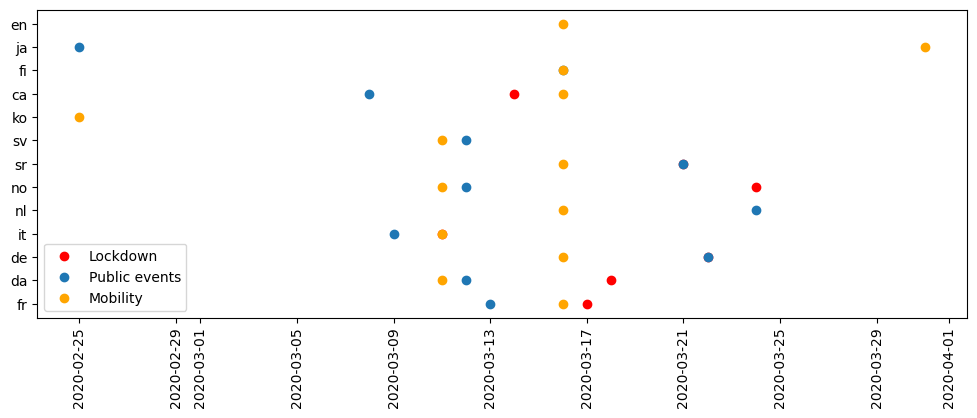

In [3]:
plt.figure(figsize=(12,4))
plt.scatter(interventions['Lockdown'],interventions['lang'],color='red',label='Lockdown')
plt.scatter(interventions['Public events banned'],interventions['lang'],label='Public events')
plt.scatter(interventions['Mobility'],interventions['lang'],color='orange',label='Mobility')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [4]:
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaT


### Topics linked

In [5]:
topics_linked=pd.read_csv('DATA/topics_linked.csv')
idx=np.where(topics_linked.dtypes==bool)[0]
topics_linked[topics_linked.columns[idx]]=topics_linked[topics_linked.columns[idx]].astype(int)

In [6]:
topics_agg=topics_linked.select_dtypes(include='int').sum().copy()
topics_agg=topics_agg.sort_values(ascending=False)

In [7]:
topics_agg.describe()

count    6.400000e+01
mean     1.824276e+05
std      2.651203e+05
min      4.301000e+03
25%      3.186950e+04
50%      8.563600e+04
75%      1.809262e+05
max      1.403864e+06
dtype: float64

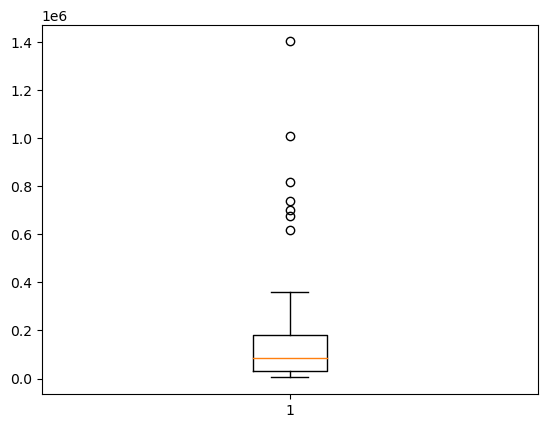

In [8]:
plt.boxplot(x=topics_agg)
plt.show()

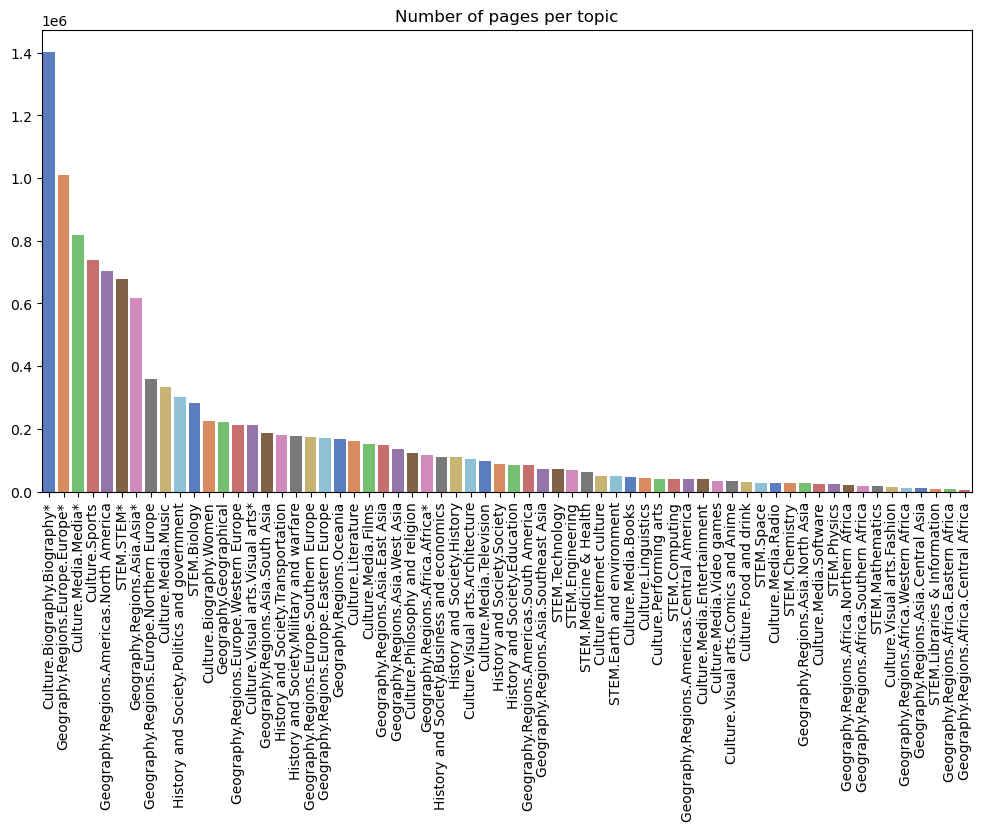

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(x=topics_agg.index,y=topics_agg,palette='muted')
plt.xticks(rotation=90)
plt.title('Number of pages per topic')
plt.show()

### Aggregated time series

In [11]:
agg_ts=pd.read_json('DATA/aggregated_timeseries.json')


In [61]:
res= process_agg_time_series(agg_ts['it']['topics']['Culture.Food and drink'])
res=res[res['year']==2020]
res

,len,sum,percent,date,year,month,day
730,5630,26570,0.004084,2020-01-01,2020,1,1
731,5630,44713,0.004348,2020-01-02,2020,1,2
732,5630,46516,0.004507,2020-01-03,2020,1,3
733,5630,38866,0.004405,2020-01-04,2020,1,4
734,5630,38867,0.004297,2020-01-05,2020,1,5
...,...,...,...,...,...,...,...
938,5630,39619,0.004557,2020-07-27,2020,7,27
939,5630,37982,0.004610,2020-07-28,2020,7,28
940,5630,36983,0.004704,2020-07-29,2020,7,29
941,5630,38255,0.004645,2020-07-30,2020,7,30


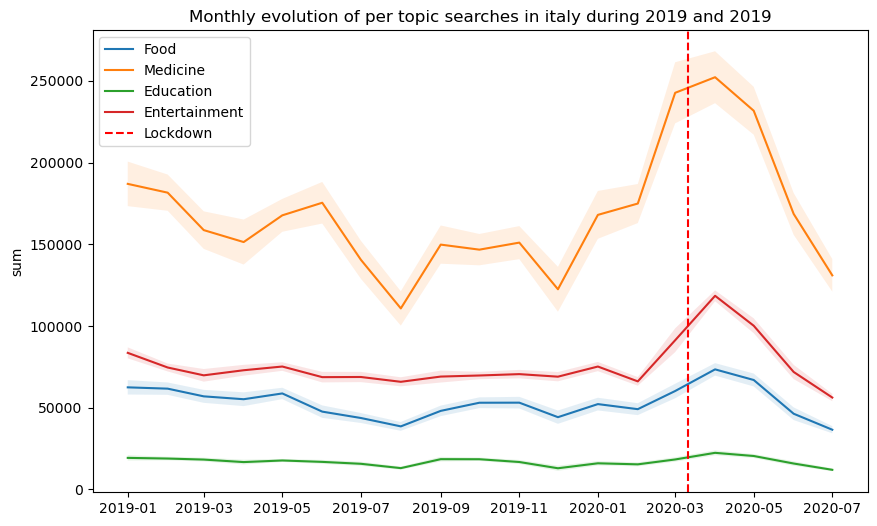

In [74]:
timeseries=[agg_ts['it']['topics']['Culture.Food and drink'],
    agg_ts['it']['topics']['STEM.Medicine & Health'],
    agg_ts['it']['topics']['History and Society.Education'],
    agg_ts['it']['topics']['Culture.Media.Entertainment']]
legends=['Food','Medicine','Education','Entertainment']
plt.figure(figsize=(10,6))
for i,ts in enumerate(timeseries):
    
    df=process_agg_time_series(ts)
    df=df.loc[df['year'].isin([2020,2019])]
    df_means=df.groupby(['year','month'])['sum'].mean().copy()
    df_sem=df.groupby(['year','month'])['sum'].sem().copy()
    df_means.index=[datetime(e[0], e[1],1) for e in df_means.index]
    df_sem.index=[datetime(e[0], e[1],1) for e in df_sem.index]
    CI=stats.t.interval(0.95, len(df_means)-1 , loc = df_means, scale = df_sem)
    sns.lineplot(df_means,label=legends[i])
    plt.fill_between(df_means.index,CI[0],CI[1],alpha=0.12)
    plt.title('Monthly evolution of per topic searches in italy during 2019 and 2019')
plt.axvline(x=interventions['Lockdown'][3],color='red', linestyle='--', label='Lockdown')
plt.legend()
plt.show()

### Mobility

In [ ]:
global_mr=pd.read_csv('DATA/Global_Mobility_Report.csv')
#global_mr.describe

In [112]:
apple_mr=pd.read_csv('DATA/applemobilitytrends-2020-04-20.csv')
#apple_mr.describe